# *Predicting Parole Violators*
<hr>
## Machine Learning Engineer Nanodegree
<hr>
Tetevi Placide Ekon   
September 22<sup>nd</sup>, 2016

## I. Definition

### Project Overview
In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from the [`United States 2004 National Corrections Reporting Program`](http://www.icpsr.umich.edu/icpsrweb/NACJD/series/38/studies/26521?archive=NACJD&sortBy=7); a census across all the United States of parole releases that occurred during 2004. We limited our focus to parolees who served no more than 6 months in prison and whose maximum sentence for all charges did not exceed 18 months. A model trained on this data that is seen as a good fit could then be used to make certain predictions about prisonners who should obtain parole and ultimately solve the problem of prisons overcrowding.


### Problem Statement
The goal of this project is to train a classification model that can tell apart a parolee that is going to violate parole and one that will not. In order to do so, we are first going to build a baseline model that always predicts the most frequent outcome i.e if the most frequent outcome was that parolees violate parole, it will always predict that same outcome for all parolees in our dataset. This model will obviously be unhelpful but its sole purpose is to serve as a baseline for performances comparison with a second model that we will then build. That second model will have to outperform our baseline model when compared using their score on the metrics used for this project.   
We will finally try to get the most out of that model by performing several parameters tuning via `gridsearch`.

### Metrics
For this project, in order to evaluate the performance of our model, we are going to use three different Metrics:  

**F1 score:**  
The first metric will be the F1 Score. It is a measure of a test's accuracy. It considers 
both the precision p and the recall r of the test to compute the score: p is the number of 
correct positive results divided by the number of all positive results, and r is the number
of correct positive results divided by the number of positive results that should have been
returned. The F1 score can be interpreted as a weighted average of the precision and recall,
where an F1 score reaches its best value at 1 and worst at 0.   
<center>F1 = $2*\frac{\text{Precision * Recall}}{\text{Precision + Recall}}$ </center>     
**Accuracy:**        
Then we will test the Accuracy of our Model. Accuracy is a common metric for binary 
classifiers; it takes into account both tru positives and true negatives with equal weight:  
<center>Accuracy = $\frac{\text{True Postives + True Negatives}}{\text{Dataset Size}}$</center>   
**AUC:**  
The third and last metric we will use for this project is the AUC or Area Under Curve which 
computes the area under the ROC curve for a given model. It tells us the ability of the model
to tell apart a true positive from a true negative.

## II. Analysis

### Data Exploration
The code cell below loads necessary Python libraries as well as the student data. The last column from this dataset, `'violator'`, will be our target label (whether the parolee violated parole or not). All other columns are features about each parolee.

In [3]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Pretty display for notebooks
%matplotlib inline

# Read parole data
parole_data = pd.read_csv("parole.csv")
print "Parole data read successfully!"

Parole data read successfully!


In [26]:
# Extract feature columns
feature_cols = list(parole_data.columns[:-1])

# Extract target column 'passed'
target_col = parole_data.columns[-1]

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = parole_data[feature_cols]
y_all = parole_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()
print "\nTarget column values:"
print y_all.head()

Feature columns:
['male', 'race', 'age', 'state', 'time.served', 'max.sentence', 'multiple.offenses', 'crime']

Target column: violator

Feature values:
   male  race   age state  time.served  max.sentence  multiple.offenses crime
0     1     1  33.2     1          5.5            18                  0     4
1     0     1  39.7     1          5.4            12                  0     3
2     1     2  29.5     1          5.6            12                  0     3
3     1     1  22.4     1          5.7            18                  0     1
4     1     2  21.6     1          5.4            12                  0     1

Target column values:
0    0
1    0
2    0
3    0
4    0
Name: violator, dtype: int64


 *As we can see, the dataset contains the following variables:  *
- `male`: 1 if the parolee is male, 0 if female
- `race`: 1 if the parolee is white, 2 otherwise
- `age`: the parolee's age (in years) when he or she was released from prison
- `state`: a code for the parolee's state. 2 is Kentucky, 3 is Louisiana, 4 is Virginia, and 1 is any other state. The three states were selected due to having a high representation in the dataset.
- `time.served`: the number of months the parolee served in prison (limited by the inclusion criteria to not exceed 6 months).
- `max.sentence`: the maximum sentence length for all charges, in months (limited by the inclusion criteria to not exceed 18 months).
- `multiple.offenses`: 1 if the parolee was incarcerated for multiple offenses, 0 otherwise.
- `crime`: a code for the parolee's main crime leading to incarceration. 2 is larceny, 3 is drug-related crime, 4 is driving-related crime, and 1 is any other crime.
- `violator (target column)`: 1 if the parolee violated the parole, and 0 if the parolee completed the parole without violation.


#### > Some Statistics about the data

In [10]:
parole_data.describe()

,male,race,age,state,time.served,max.sentence,multiple.offenses,crime,violator
count,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,0.807407,1.423704,34.512296,2.887407,4.198074,13.056296,0.536296,2.059259,0.115556
std,0.394628,0.494511,10.351541,1.226224,1.226855,3.056797,0.499051,1.135892,0.319928
min,0.000000,1.000000,18.400000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,25.350000,2.000000,3.250000,12.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,33.700000,3.000000,4.400000,12.000000,1.000000,2.000000,0.000000
75%,1.000000,2.000000,42.550000,4.000000,5.200000,15.000000,1.000000,3.000000,0.000000
max,1.000000,2.000000,67.000000,4.000000,6.000000,18.000000,1.000000,4.000000,1.000000


Let's begin by investigating the dataset to determine how many parolees we have information on, and learn about the parole violation rate among these parolees. In the code cell below, we computed the following:

- The total number of parolees, `n_parolees`.
- The total number of features for each parolee, `n_features`.
- The number of those parolees who violated parole, `n_violators`.
- The number of those parolees who did not violate parole, `n_non_violators`.
- The parole violation rate, `viol_rate`, in percent (%).


In [11]:
# The total number of parolees
n_parolees = len(parole_data[0:])

# The total number of features for each parolee
n_features = len(parole_data.columns[:-1])

# The number of those parolees who violated parole
n_violators = len(parole_data[parole_data.violator == 1])

# The number of those parolees who did not violate parole
n_non_violators = len(parole_data[parole_data.violator == 0])

# The parole violation rate
viol_rate = n_violators*100.0/n_parolees

# Print the results
print "Total number of parolees: {}".format(n_parolees)
print "Number of features: {}".format(n_features)
print "Number of parolees who violated parole: {}".format(n_violators)
print "Number of parolees who did not violate parole: {}".format(n_non_violators)
print "Parole violation rate: {:.2f}%".format(viol_rate)

Total number of parolees: 675
Number of features: 8
Number of parolees who violated parole: 78
Number of parolees who did not violate parole: 597
Parole violation rate: 11.56%


#### > Proportion of male and female violators


In [12]:
# The proportion of male parole violators
males_data = parole_data[parole_data.male == 1]
male_violators = males_data[males_data.violator == 1]
prop_male_viol = len(male_violators)/float(n_violators)

# The proportion of female parole violators
females_data = parole_data[parole_data.male == 0]
female_violators = females_data[females_data.violator == 1]
prop_female_viol = len(female_violators)/float(n_violators)

# Print the results
print "Proportion of male parole violators: {}".format(prop_male_viol)
print "Proportion of female parole violators: {}".format(prop_female_viol)

Proportion of male parole violators: 0.820512820513
Proportion of female parole violators: 0.179487179487


#### > Most common crime in Kentucky

*Below is just the implementation of a function that returns the most frequent element from a list:* `most_common()`

In [13]:
import itertools
import operator

def most_common(L):
  # get an iterable of (item, iterable) pairs
  SL = sorted((x, i) for i, x in enumerate(L))
  # print 'SL:', SL
  groups = itertools.groupby(SL, key=operator.itemgetter(0))
  # auxiliary function to get "quality" for an item
  def _auxfun(g):
    item, iterable = g
    count = 0
    min_index = len(L)
    for _, where in iterable:
      count += 1
      min_index = min(min_index, where)
    # print 'item %r, count %r, minind %r' % (item, count, min_index)
    return count, -min_index
  # pick the highest-count/earliest item
  return max(groups, key=_auxfun)[0]

Computing the most frequent crime in Kentucky   
> `crime` values are numerically coded as this:    
* 2 is larceny, 
* 3 is drug-related crime, 
* 4 is driving-related crime, 
* and 1 is any other crime.


In [14]:
# values computation
kentucky_data = parole_data[parole_data.state == 2]
most_com_ken_val = most_common(kentucky_data.crime)
most_com_ken = ''
if most_com_ken_val == 2:
    most_com_ken = 'Larceny'
elif most_com_ken_val == 3:
    most_com_ken = 'Drug-related crime'
elif most_com_ken_val == 4:
    most_com_ken = 'Driving-related crime'
else:
    most_com_ken = 'Other crime'

# Printing the results
print "The Most common Crime in Kentucky is a {}".format(most_com_ken)

The Most common Crime in Kentucky is a Drug-related crime


### Exploratory Visualization

#### > Age distribution of the parolees

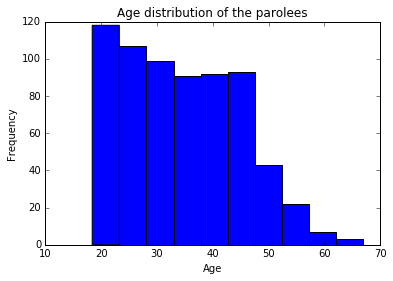

In [16]:
import matplotlib.pyplot as plt

plt.hist(X_all['age'])
plt.title("Age distribution of the parolees")
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

As we can see, the first bin in this histogram represents parolees who are between 20 and 24 years old and the last bin represents parolees who are between 65 and 69 years old.  
The tallest bar corresponds to the age bracket with the most parolees, which is 20-24 and the shortest bar which is 65-69, corresponds to the age bracket with the least parolees. This seems to be consitent given that old people commit less crime than young people. 



#### > Age distribution with respect to Sex

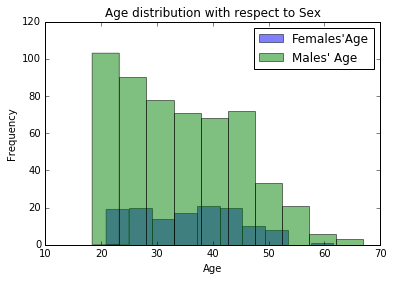

In [17]:
plt.hist(females_data['age'], alpha=0.5, label="Females'Age")
plt.hist(males_data['age'], alpha=0.5, label="Males' Age")
plt.legend(loc='upper right')
plt.title("Age distribution with respect to Sex")
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

The plot above shows how the age distribution of male parolees (green plot) compares to the age distribution of female parolees (blue plot).  
Looking at the blue histogram, we can see that the tallest bar corresponds to the age bracket 35-39.   
The age bracket with the most female parolees is thus different from that of the most male parolees which is the same as the cumulated one 20-24.  
This also seems consistent since there are more male parolees than female as we have already shown by calculating their respective proportion in the statistics section:   
>Proportion of male parole violators: 0.820512820513  
Proportion of female parole violators: 0.179487179487  

If you look at the plot, you can see that there are no female parolees in the age groups 20-22, 55-59, and 65-69 (the bars have height zero).

#### > Time Served  
Now let's explore another aspect of the data: the amount of time served by parolees. Let's create a basic histogram, but this time with `time.served` on the x-axis, the bin width being one month.

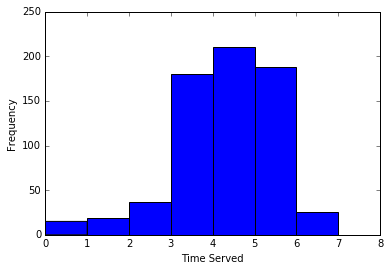

In [18]:
bins = range(9)
plt.hist(X_all['time.served'], bins)
plt.xlabel('Time Served')
plt.ylabel('Frequency')
plt.show()

The highest bar corresponds to between 4 and 5 months, so according to the above histogram, most parolees spent between 4 and 5 months. To be more precise, let's reduce the bin size.

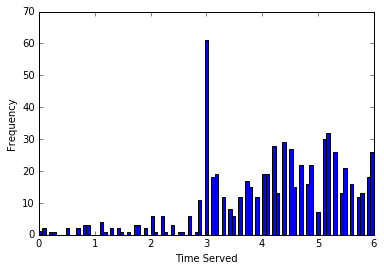

In [19]:
bins = np.linspace(0, 6, 100)
plt.hist(X_all['time.served'], bins)
plt.xlabel('Time Served')
plt.ylabel('Frequency')
plt.show()

Now, the highest bar corresponds to between 3.0 and 3.1 months. We thus have to be very careful when choosing the binwidth since as shown above - it can significantly affect the interpretation of a histogram.

#### > Time Served With respect to crime type
Now we want to visualize the `time.served` per crime type. The crime values are numerically coded as this:    
* 2 is larceny, 
* 3 is drug-related crime, 
* 4 is driving-related crime, 
* and 1 is any other crime.

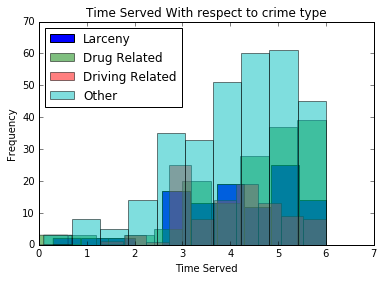

In [21]:
# Different type of crimes
larceny = X_all[X_all.crime == 2]
drug_r = X_all[X_all.crime == 3]
driving_r = X_all[X_all.crime == 4]
other = X_all[X_all.crime == 1]

# Plotting the histograms
plt.hist(larceny['time.served'], alpha= 1, label="Larceny")
plt.hist(drug_r['time.served'], alpha=0.5, label="Drug Related")
plt.hist(driving_r['time.served'], alpha=0.5, label="Driving Related")
plt.hist(other['time.served'], alpha=0.5, label="Other")
plt.legend(loc='upper left')
plt.title("Time Served With respect to crime type")
plt.xlabel('Time Served')
plt.ylabel('Frequency')
plt.show()

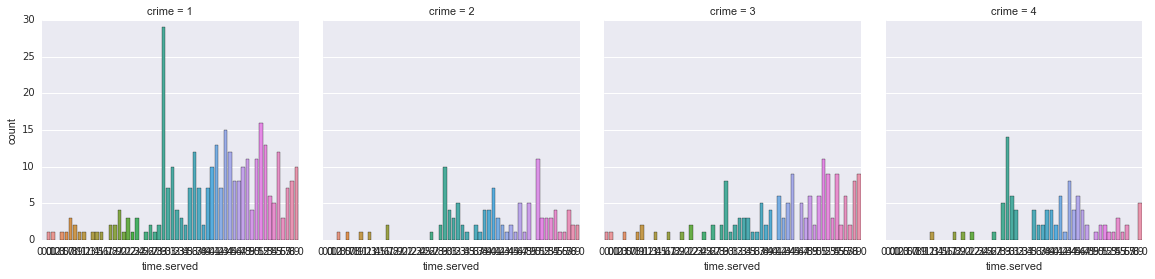

In [22]:
%matplotlib inline
import seaborn as sns
sns.factorplot("time.served", col="crime", data=parole_data, kind='count');

The histograms above show many facts among which are:
- the fact that driving-related crimes have no observations where time served is less than one month. This means according to our dataset, that the time served for driving related cars is usually more than a month 

- the fact that for drug-related crimes, the 5-6 month prison terms' fequencies exceed the frequencies of the other crime types' term length (if we ignore the crime type Other). This means that generally you serve more time for drug-related crimes.

#### > Violators by state

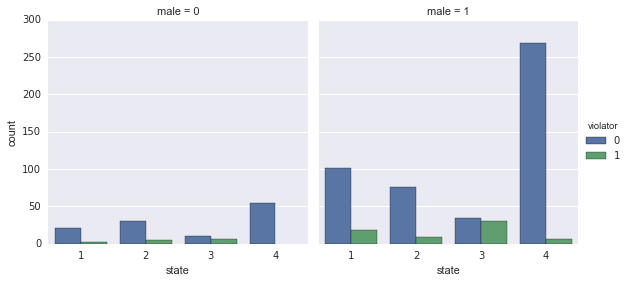

In [23]:
%matplotlib inline
import seaborn as sns
sns.factorplot("state", col="male", data=parole_data, hue='violator', kind='count');

The histograms above show the crime violators per state and per sex. We can see that parolees from a state like `Virginia (coding = 4)` rarely violate their parole and that almost `50%` of parolees from a state like `Louisiana (coding = 3)` always violate their parole.

### Algorithms and Techniques
For this project we will be using `Logistic Regression` to build our model. `Logistic Regression` models are a good fit for this particular problem because they are used to predict categorical outcomes from prediction variables that are continuous and/or categorical, unlike normal regression where having a categorical outcome violates the linearity assumption.  
`Logistic regression` deals with this problem by using a
logarithmic transformation on the outcome variable which allows us to model a nonlinear association in a linear way.  It expresses the linear regression equation in logarithmic terms (called the logit).  
The only real limitation of logistic regression is that the outcome variable must be discrete.   
Assumptions made by logistic regression models are :  
- Absence of multicollinearity 
- Absence of outliers 
- Independence of errors  

All of which we can assume for our parolees.  

### Benchmark
Our benchmark for this project will be the `Accuracy score` of our baseline model; our target model will have to outperform our baseline model for it to start to become useful for our purpose of predicting parole violators.

## III. Methodology

### Data Preprocessing  
Our dataset were clearly structured; all preprocessing measures we had to take were:  
- seperating it into a `Feature group (dataframe containing all prediction variables)` and a `Target column (column containing all the values of the target variable)`, 
- identifying unordered factors like -- male, race, state and violator -- and removing those with 3 or more levels.  

It did not need any other preprocessing which gave us more time to focus on visualizing it and extracting some useful informations from it.

### Implementation


#### > Dealing with unordered factors  
As identified in the `Data Preprocessing` subsection, there are 4 unordered factors in our dataset -- `male`, `race`, `state` and `violator` -- since  only `state` and `crime` have at least 3 levels in the dataset, they are the ones we will need to convert into factors for our prediction problem.

In [25]:
# Converting variables state and crime to factors
parole_data['state'] = parole_data['state'].astype(object)
parole_data['crime'] = parole_data['crime'].astype(object)

#### >  Training and Testing Data Split
For the next step, we split the data (both features and corresponding labels) into training and test sets. In the code cell below, we did the following implementions:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Used 70% of the data for training points and 30% for testing points.
  - Set a `random_state` for the `train_test_split` function from the `sklearn.cross_validation` library.
  - Stored the results in `X_train`, `X_test`, `y_train`, and `y_test`.  

Also, the main characteristics of our dataset are as computed above (in the statistics section):  
>Total number of parolees: 675  
Number of features: 8  
Number of parolees who violated parole: 78  
Number of parolees who did not violate parole: 597  
Parole violation rate: 11.56%  

As we can see, our dataset is small and slightly unbalanced (There are less parole violators than non parole violators. Even though it is only necessary in the case of heavily unbalanced datasets, we chose here to address the unbalanced nature of our dataset with S`tratified K-fold` and `Stratified cross-validation` as stratification is preserving the percentage of samples for each class. To implement this we set the parameter `stratify = y_all`



In [32]:
# Import train_test_split function
from sklearn.cross_validation import train_test_split

# Shuffle and split the dataset into training(70%) and testing points(30%) 
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify = y_all, test_size=.30, random_state=144)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 472 samples.
Testing set has 203 samples.


Let's now check if by setting the `stratify` parameter above, we managed to obtain the same proportion of parole violation rate in the train set as in the test set.

In [28]:
print "Parole violation rate of train set: {:.2f}%".format(100*(y_train == 1).mean())
print "Parole violation rate of test set: {:.2f}%".format(100*(y_test == 1).mean())

Parole violation rate of train set: 11.65%
Parole violation rate of test set: 11.33%


The above print statements show that stratifying helps us maintain the class imbalance across both the training and the testing sets. 

####  >  Building a Baseline Model `(to serve as a benchmark)`

Since there are far more non violators, let's set our baseline model to be one predicting that every parolee is a non violator. The code below calculates its accuracy.

In [33]:
test_non_violators = len(y_test[y_test == 0])

("The accuracy of a simple model that predicts that every parolee is a non-violator is {}".format(
                                                            test_non_violators/float(len(y_test))))

'The accuracy of a simple model that predicts that every parolee is a non-violator is 0.886699507389'

The accuracy of this baseline model is very high and although the model itself is unuseful we will need to find a model with an accuracy at least as high but that can tell apart non-violators from violators meaning its Are Under Curve (AUC) will have to significant. Let's try to compute the AUC for our baseline model.

In [34]:
from sklearn import metrics
# Prediction of baseline model -- All parolees are non violators
pred = np.zeros((len(y_test),), dtype=np.int)

# Computing the AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.5

The result is 0.5 -- our baseline model is thus completely unable to tell apart a non violator from a violator.

#### > Building a Logistic Regression Model



Here are some helper functions for what's to follow

In [38]:
# Helper functions 
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Train the classifier
    mdl = clf.fit(X_train, y_train)
    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Make predictions
    y_pred = clf.predict(features)
    
    # Rreturn results
    return f1_score(target.values, y_pred, pos_label= 1 )


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

With the predefined functions above, we will now import the Logistic Regression learning model and run the train_predict function for it. To see how well it does on multiple training set sizes will also train and predict on it for five different training set sizes: 100 to 500. 

In [101]:
# Import LogisticRegression Model
from sklearn.linear_model import LogisticRegression

# Model Initialisation
clf = LogisticRegression(random_state = 0)

# Loop through train sizes
for n in [100, 200, 300, 400, 500]:
    train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)

Training a LogisticRegression using a training set size of 100. . .
F1 score for training set: 0.4348.
F1 score for test set: 0.3243.
Training a LogisticRegression using a training set size of 200. . .
F1 score for training set: 0.3590.
F1 score for test set: 0.2759.
Training a LogisticRegression using a training set size of 300. . .
F1 score for training set: 0.1395.
F1 score for test set: 0.0769.
Training a LogisticRegression using a training set size of 400. . .
F1 score for training set: 0.0727.
F1 score for test set: 0.0800.
Training a LogisticRegression using a training set size of 472. . .
F1 score for training set: 0.0667.
F1 score for test set: 0.0800.


 *Classifer - LogisticRegression*  

| Train set size    | F1 Score (train)         |   F1 Score (test)       |
| :---------------: | :---------------------: | :---------------------: | 
| 100               |       0.4348            |       0.3243            | 
| 200               |       0.3590            |       0.2759            | 
| 300               |       0.1395            |       0.0769            | 
| 400               |       0.0727            |       0.0800            | 
| 500               |       0.0667            |       0.0800            | 


The F1 Score tends to decrease both on the train and test sets, as we increase the Train size. To get a closer look at how the model is predicting the label, let's plot a confusion matrix.

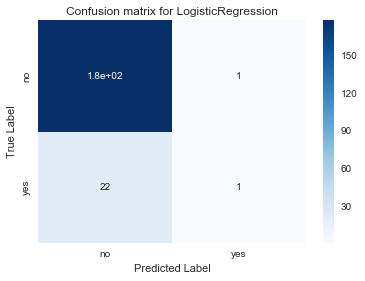

In [201]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

# Compute confusion matrix for the model
cm = confusion_matrix(y_test.values, clf.predict(X_test))

# View with a heatmap
sns.heatmap(cm, annot = True, cmap='Blues', xticklabels=['no','yes'], yticklabels=['no','yes'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion matrix for {}'.format(clf.__class__.__name__));

There are 203 observations in the test set. The accuracy (percentage of values on the diagonal) is $\frac{180+1}{203} = 0.891$.   
The sensitivity (proportion of the actual violators we got correct) is $\frac{1}{1+22} = 0.04$,  
and the specificity (proportion of the actual non-violators we got correct) is $\frac{180}{180+1} = 0.994    $.

The accuracy of this model is bigger than that of our baseline model which was 0.886. This model is thus better. Let's compute its AUC then:  

In [218]:
# Computing the AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict(X_test), pos_label=1)
metrics.auc(fpr, tpr)

0.51896135265700483

We notice a slight improvement over the AUC of the baseline which was 0.50

Let's consider a parole board using this model to predict whether parolees will be violators or not. The job of a parole board is to make sure that a prisoner is ready to be released into free society, and therefore parole boards tend to be particularily concerned about releasing prisoners who will violate their parole. It is more likely that the board assigns more cost to a false negative than a false positive and since this model has a huge rate of false negatives (22/23) it is unuseful for a parole board.

### Refinement
Let's try tuning the model using grid search (`GridSearchCV`). We will need to use the entire training set for this. In the code cell below, we implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters to tune for the model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [108]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Create the parameters list to tune
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Initialize the classifier
clf = LogisticRegression(random_state = 7)

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label = 1)

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=f1_scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Tuned model has a training F1 score of 0.0952.
Tuned model has a testing F1 score of 0.1538.


## IV. Results  
### Model Evaluation and Validation

Let's now see how well our tuned model does on multiple training set sizes ranging from 100 to 500

In [109]:
# Loop through train sizes
for n in [100, 200, 300, 400, 500]:
    train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)

Training a LogisticRegression using a training set size of 100. . .
F1 score for training set: 0.4444.
F1 score for test set: 0.4651.
Training a LogisticRegression using a training set size of 200. . .
F1 score for training set: 0.3500.
F1 score for test set: 0.3030.
Training a LogisticRegression using a training set size of 300. . .
F1 score for training set: 0.1667.
F1 score for test set: 0.2581.
Training a LogisticRegression using a training set size of 400. . .
F1 score for training set: 0.0727.
F1 score for test set: 0.0800.
Training a LogisticRegression using a training set size of 472. . .
F1 score for training set: 0.0952.
F1 score for test set: 0.1538.


 *Classifer - LogisticRegression*  _Untuned_

| Train set size    | F1 Score (train)         |   F1 Score (test)       |
| :---------------: | :---------------------: | :---------------------: | 
| 100               |       0.4348            |       0.3243            | 
| 200               |       0.3590            |       0.2759            | 
| 300               |       0.1395            |       0.0769            | 
| 400               |       0.0727            |       0.0800            | 
| 500               |       0.0667            |       0.0800            | 

*Classifer - LogisticRegression*  _Tuned_

| Train set size    | F1 Score (train)         |   F1 Score (test)       |
| :---------------: | :---------------------: | :---------------------: | 
| 100               |       0.4444            |       0.4651            | 
| 200               |       0.3500            |       0.3030            | 
| 300               |       0.1667            |       0.2581            | 
| 400               |       0.0727            |       0.0800            | 
| 500               |       0.0952            |       0.1538            | 


There has obviously been some improvements in the results; let's check this fact by also computing the Area under Curve (AUC) for our tuned model.

In [222]:
# Computing the AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict(X_test), pos_label=1)
metrics.auc(fpr, tpr)

0.54070048309178742

There is in fact a slight improvement but the model still performs poorly when it comes to predicting violators

The final model's F<sub>1</sub> score is 0.0952 for the training set which is bigger than that of the untuned model on a training set of this size   
The final model's F<sub>1</sub> score is 0.1538 for the testing set which is also bigger than that of the untuned model a training set of this size 

### Justification  
We noticed a slight improvement over the AUC of the baseline which was 0.50.  
If a parole board used the model for parole decisions, a negative prediction would lead to a prisoner being granted parole, while a positive prediction would lead to a prisoner being denied parole. The parole board would experience more regret for releasing a prisoner who then violates parole (a negative prediction that is actually positive, or false negative) than it would experience for denying parole to a prisoner who would not have violated parole (a positive prediction that is actually negative, or false positive).

## V. Conclusion

### Free-Form Visualization

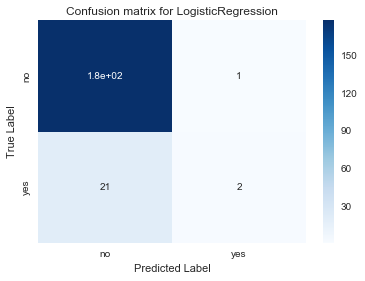

In [223]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

# Compute confusion matrix for the model
cm = confusion_matrix(y_test.values, clf.predict(X_test))

# View with a heatmap
sns.heatmap(cm, annot = True, cmap='Blues', xticklabels=['no','yes'], yticklabels=['no','yes'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion matrix for {}'.format(clf.__class__.__name__));

### Reflection  
In this project, we have gone from a basic and naive model that predicts all parolees are not going to violate parole to a less naive Logistic Regression model with a bigger accuracy, F1 score and AUC.  
One particular aspect of the project was the visualisation part, how plotting certain variables one against each other can provide cues and intel into a dataset and how some visualisations could also be misleading.   
Apart from that, it has been nice to start with a basic model and to watch that model evolve overtime, becoming more and more able to predict our outcome variable.

### Improvement


This model has a much higher specificity than sensitivity, meaning it does a better job predicting parolees who are not going to violate parole. Since we want to be confident a parolee won't violate parole before we release him, we can expect more from its ability to predict parolees who are going to violate parole.  
To further improve the model, we can consider actually going well beyond grid search and implement ‘pipelines’ where the whole machine learning process becomes 'grid-searchable' and we can parameterize and search the whole process though cross validation. We can also try out several algorithms automatically!